In [2]:
##################################################
# Please include all the common packages here :) #
##################################################

using Images, DataFrames, FixedPointNumbers, PyPlot, Colors, ProgressMeter

# loads all jpg image files inside the directory
function get_image_files(image_dir)
    # get all the files in the directory
    dir_contents = readdir(image_dir)
    dir_contents = [ join([image_dir, dir_contents[i]], "/") for i in 1:length(dir_contents) ]
    
    # retain only jpg image files
    image_files = filter(x->ismatch(r"(.jpg$)|(.jpeg$)"i, x), dir_contents)
    
    # return the paths to the jpg image files
    return image_files
end

# converts image to a h x w matrix
#   h = height
#   w = width
function convert_image_to_mat(image)
    image_mat = reinterpret(UInt8, separate(image).data)
    return image_mat
end

# converts a h x w matrix to an Images module image
function convert_mat_to_image(image_mat)
    image = colorim(image_mat)
    return image
end

# load a list of image files as a cell array of image matrices
function load_images_as_cellarray_mats(image_files)
    images_mat = cell(length(image_files),1)
    for (image_n, image_file) in enumerate(image_files)
        image = load(image_file)
        image_mat = convert_image_to_mat(image)
        
        # fix for RGB4 seen on Mac because of ImageMagick behavior
        #  read only RGB (ignore the 4th value)
        image_mat = image_mat[:,:,1:3]
        
        images_mat[image_n] = image_mat
    end
    return images_mat
end

# convert a cell array of image matrices to a cell array of images
function load_cellarray_mats_as_images(images_mat)
    images = cell(length(images_mat),1)
    for (image_n, image_mat) in enumerate(images_mat)
        image = convert_mat_to_image(image_mat)
        images[image_n] = image
    end
    return images
end

# silly way to make all images the same size
function subsample_cellarray_mats(images_mat, desired_size)
    for (image_n, image) in enumerate(images_mat)
        images_mat[image_n] = image[1:desired_size[2], 1:desired_size[1], :]
    end
    return images_mat
end

# function to scale one basis image to the desired size
function scale_image(image,desired_size)
    n_combine = floor(Int64, size(image, 1)/desired_size[1] + 0.5)
    n_pixel = n_combine*n_combine
    temp=image[1:desired_size[2], 1:desired_size[1], :]
    for i in 1:desired_size[2]
        for j in 1:desired_size[1]
            sub = image[(i-1)*n_combine+(1:n_combine),(j-1)*n_combine+(1:n_combine),:]
            for c in 1:3
                pixel=convert(UInt8,round(sum(sum(sub[:,:,c]))/n_pixel))
                temp[i,j,c]=pixel
            end
        end
    end
    return temp
end

# scale the whole base array
function scale_cellarray_mats(images_mat, desired_size)
    for (image_n, image) in enumerate(images_mat)
            images_mat[image_n] = scale_image(image,desired_size)
    end
    return images_mat
end

# downscale image by a factor
function downscale_image(image, factor)
    if factor == 1
        return image
    else
        desired_height = div(size(image,1), factor)
        desired_width = div(size(image,2), factor)
        desired_size = (desired_width, desired_height)
        
        return scale_image(image, desired_size)
    end
end

#Convert rgb image to grayscaled image
function rgb2gray(images)
    images_gray_mat = cell(length(images),1)
    for (image_n, image) in enumerate(images)
        image_gray = convert(Image{Gray{Ufixed8}}, image)
        image_mat = reinterpret(UInt8, separate(image_gray).data)
        image_gray_mat=rand(UInt8, size(image_mat,1), size(image_mat,2),3)
        image_gray_mat[:,:,1]= image_mat[:,:,1]
        image_gray_mat[:,:,2]= image_mat[:,:,1]
        image_gray_mat[:,:,3]= image_mat[:,:,1]      
        images_gray_mat[image_n] = image_gray_mat
    end
    return images_gray_mat
end

#Scale a grayscale image
function scale_gray_image(image,desired_size)
     n_combine = 64/desired_size[1]
    n_pixel = n_combine*n_combine
    temp=image[1:desired_size[2], 1:desired_size[1], :]
    for i in 1:desired_size[2]
        for j in 1:desired_size[1]
            sub = image[(i-1)*n_combine+(1:n_combine),(j-1)*n_combine+(1:n_combine),:]
            
            pixel=convert(UInt8,round(sum(sum(sub[:,:,1]))/n_pixel))
            temp[i,j,1]=pixel
            end
        end
    temp[:,:,2]=temp[:,:,1]
    temp[:,:,3]=temp[:,:,1]
    return temp
end

#Scale an array of grayscale images
function scale_cellarray_gray_mats(images_mat, desired_size)
    for (image_n, image) in enumerate(images_mat)
        images_mat[image_n] = scale_gray_image(image,desired_size)
    end
    return images_mat
end

#Convert the image type to Int64 for easy calculation of image histogram
function convert_image_mat_to_Int64(image_mat)
    image_mat1=rand(Int64,size(image_mat,1),size(image_mat,2),size(image_mat,3))
    for i in 1:size(image_mat,1)
        for j in 1:size(image_mat,2)
            for k in 1:size(image_mat,3)
                image_mat1[i,j,k]=convert(Int64, image_mat[i,j,k])
            end
        end
    end
    
    return image_mat1
end
; # suppress output

In [23]:
using JuMP, Mosek
n_colors = 1

function pickOptHist(sub_test_image,optimize_color,n_basis,hist_basis_mat)
    corr = zeros(n_basis,1)
    m = Model(solver = MosekSolver(LOG=1))
    @defVar(m, pick_basis[1:n_basis], Bin)
    @defVar(m, AbsMatchError[1:n_colors] >= 0)
    @defVar(m,test_image_hist_mean>=0)    
    @addConstraint(m, sum(pick_basis) == 1)
    if optimize_color
        (nothing,test_image_hist1) = hist(vec(sub_test_image[:,:,1]),-1:255)
        (nothing,test_image_hist2) = hist(vec(sub_test_image[:,:,2]),-1:255)
        (nothing,test_image_hist3) = hist(vec(sub_test_image[:,:,3]),-1:255)
        test_image_hist=test_image_hist1+test_image_hist2+test_image_hist3
        test_image_hist_mean=test_image_hist - mean(test_image_hist)
    else
        (nothing,test_image_hist) = hist(vec(sub_test_image[:,:,1]),-1:255)
        test_image_hist_mean=test_image_hist - mean(test_image_hist)
    end
    
    for basis in 1:n_basis
        corr_num=(sum(test_image_hist_mean.*hist_basis_mat[basis]))
        corr[basis]=sum(corr_num/((sqrt(sum(test_image_hist_mean.^2))).*sqrt(sum(hist_basis_mat[basis].^2))));
    end
    
    #Check if value is NaN
    for basis in 1:n_basis
        if isequal(corr[basis],NaN)
            corr[basis]=0
        end
    end
    
    @defExpr(m, Correlation, sum(dot(pick_basis,corr[:])))
    @setObjective(m, Max, Correlation)
        
    status = solve(m)
    opt_pick_basis = getValue(pick_basis)
    chosen_basis = findfirst(opt_pick_basis)
    
    return chosen_basis
end;

In [9]:
image_files = get_image_files("./Basis_1")
base_size = 8
images_mat = load_images_as_cellarray_mats(image_files)


test_image_files = get_image_files("./Test")
test_images_mat = load_images_as_cellarray_mats(test_image_files);

In [22]:
function histogram_optimization(test_image_mat,images_mat,base_size,optimize_color)
    image_files=load_cellarray_mats_as_images(images_mat)
    images_gray_mat=rgb2gray(image_files)
    desired_size = (base_size, base_size)
    images_mat = scale_cellarray_mats(images_mat, desired_size)
    test_images =load_cellarray_mats_as_images(test_image_mat)
    test_image_gray_mat=rgb2gray(test_images)
    test_image = test_image_mat[1]
    test_image_gray = test_image_gray_mat[1]
    n_basis = length(images_mat)
    w_basis = size(images_mat[1], 2)
    h_basis = size(images_mat[1], 1)
    w_test_image = size(test_image, 2)
    h_test_image = size(test_image, 1)

    n_basis_width = round(Int64, w_test_image/w_basis)
    n_basis_height = round(Int64, h_test_image/h_basis)
    
    
    n_colors=1
    basis_choice = zeros(n_basis_height, n_basis_width)
    mosaic_image = copy(test_image)
    hist_basis_mat = cell(n_basis,1)
    hist_basis_mat1 = cell(n_basis,1)
    hist_basis_mat2 = cell(n_basis,1)
    hist_basis_mat3 = cell(n_basis,1)

    test_image1=rand(Int64,size(test_image,1),size(test_image,2),size(test_image,3))
    images_mat1 = cell(length(images_mat),1)
    test_image_gray1=rand(Int64,size(test_image_gray,1),size(test_image_gray,2),size(test_image_gray,3))
    images_gray_mat1 = cell(length(images_gray_mat),1)
    for basis in 1:n_basis
        images_mat1[basis]=rand(Int64,size(images_mat[basis],1),size(images_mat[basis],2),size(images_mat[basis],3))
     
    end
    for basis in 1:n_basis
        images_gray_mat1[basis]=rand(Int64,size(images_gray_mat[basis],1),size(images_gray_mat[basis],2),size(images_gray_mat[basis],3))
    end
    test_image1 = convert_image_mat_to_Int64(test_image)
    test_image_gray1=convert_image_mat_to_Int64(test_image_gray)
    for basis in 1:n_basis
        images_mat1[basis]=convert_image_mat_to_Int64(images_mat[basis])
        images_gray_mat1[basis]=convert_image_mat_to_Int64(images_gray_mat[basis])
    end
@showprogress 1 for j = 1:n_basis_height
    for i = 1:n_basis_width
       
       if optimize_color
            n_colors=3
             # pick out the target grid
            sub_test_image = test_image1[(j-1)*h_basis+(1:h_basis),(i-1)*w_basis+(1:w_basis),:]
                for basis in 1:n_basis
                (a,hist_basis_mat1[basis]) = hist(vec(images_mat1[basis][:,:,1]),-1:255)
                (a,hist_basis_mat2[basis]) = hist(vec(images_mat1[basis][:,:,2]),-1:255)
                (a,hist_basis_mat3[basis]) = hist(vec(images_mat1[basis][:,:,3]),-1:255) 
                hist_basis_mat[basis]= hist_basis_mat1[basis]+hist_basis_mat2[basis]+hist_basis_mat3[basis]
                hist_basis_mat[basis]=hist_basis_mat[basis]-mean(hist_basis_mat[basis])
                end
       else 
            n_colors=1
             # pick out the target grid
            sub_test_image = test_image_gray1[(j-1)*h_basis+(1:h_basis),(i-1)*w_basis+(1:w_basis),:]  
            for basis in 1:n_basis
                (a,hist_basis_mat[basis]) = hist(vec(images_gray_mat1[basis]),-1:255) #Number of bins used in histogram =60
                hist_basis_mat[basis]=hist_basis_mat[basis]-mean(hist_basis_mat[basis])
                
            end  
        end
            chosen_basis = pickOptHist(sub_test_image,optimize_color,n_basis,hist_basis_mat)
         basis_choice[j,i] = chosen_basis
       
         if optimize_color
            mosaic_image[ (j-1)*h_basis+(1:h_basis) , (i-1)*w_basis+(1:w_basis) , : ] = images_mat[chosen_basis]
           
        else
            mosaic_image[ (j-1)*h_basis+(1:h_basis) , (i-1)*w_basis+(1:w_basis),:] = images_gray_mat[chosen_basis]
        end      
        
    end
end
if optimize_color
     # plot two images side by side to see how we did
    imshow([test_image mosaic_image]);
else
    imshow([test_image_gray mosaic_image]);
end
    
end

;   

Progress: 100% Time: 0:03:18

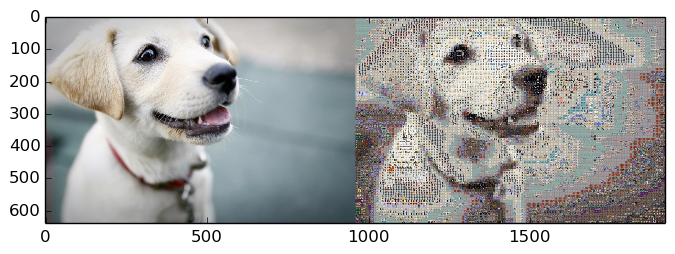

PyObject <matplotlib.image.AxesImage object at 0x7f3aca1f1b50>

In [24]:
histogram_optimization(test_images_mat,images_mat,8,true)